In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:
import os
from PIL import Image

def load_images_from_dir(directory):
    image_list = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(directory, filename)
            image = Image.open(image_path)
            image_list.append(image)
    return image_list



In [3]:
directory_path = "data/monet_jpg/"
monet_image_list = load_images_from_dir(directory_path)
print("Number of images loaded:", len(monet_image_list))

Number of images loaded: 300


In [4]:
directory_path = "data/photo_jpg/"
image_list = load_images_from_dir(directory_path)
print("Number of images loaded:", len(image_list))

Number of images loaded: 7038


In [59]:

batch_size = 10
# Define paths to the Monet and photo data folders
monet_data_path = 'data/monet_jpg/'
photo_data_path = 'data/photo_jpg/'

# Load Monet images dataset
monet_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    monet_data_path,
    labels=None,  # No labels since it's an unsupervised task
    label_mode=None,  # No labels mode
    batch_size=batch_size,  # Specify batch size
    image_size=(256, 256),  # Resize images to 256x256
    shuffle=True  # Shuffle the data
)

# Load photo images dataset
photo_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    photo_data_path,
    labels=None,
    label_mode=None,
    batch_size=batch_size,
    image_size=(256, 256),
    shuffle=True
)

# Combine Monet and photo datasets
combined_dataset = tf.data.Dataset.zip((monet_dataset, photo_dataset))



Found 300 files belonging to 1 classes.
Found 7038 files belonging to 1 classes.


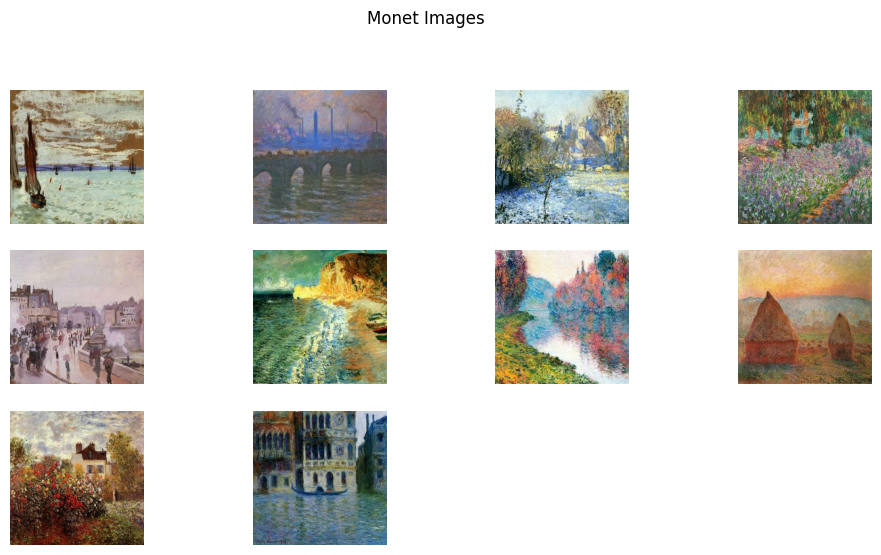

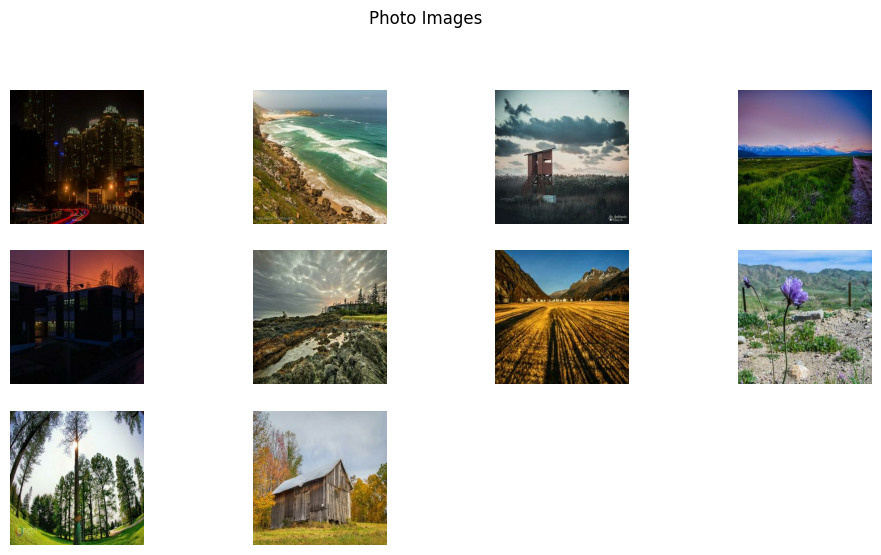

In [60]:
import matplotlib.pyplot as plt

# Function to plot images from a dataset batch
def plot_images_from_batch(dataset, title):
    # Get one batch of images from the dataset
    for images_batch in dataset.take(1):
        # Create a figure with a larger size
        plt.figure(figsize=(12, 8))
        # Plot each image in the batch
        for i, image in enumerate(images_batch):
            plt.subplot(4, 4, i + 1)
            plt.imshow(image.numpy().astype("uint8"))  # Convert to uint8 for plotting
            plt.axis("off")
        # Set title and show plot
        plt.suptitle(title)
        plt.show()

# Plot one batch of Monet images
plot_images_from_batch(monet_dataset, "Monet Images")

# Plot one batch of photo images
plot_images_from_batch(photo_dataset, "Photo Images")


In [61]:
# Define Generator model
def build_generator(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    
    # Encoder
    conv1 = layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=RandomNormal(stddev=0.02))(inputs)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Activation('relu')(conv1)
    
    conv2 = layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=RandomNormal(stddev=0.02))(conv1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Activation('relu')(conv2)
    
    # Bottleneck
    conv3 = layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=RandomNormal(stddev=0.02))(conv2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Activation('relu')(conv3)
    
    # Decoder
    deconv1 = layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=RandomNormal(stddev=0.02))(conv3)
    deconv1 = layers.BatchNormalization()(deconv1)
    deconv1 = layers.Activation('relu')(deconv1)
    
    deconv2 = layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=RandomNormal(stddev=0.02))(deconv1)
    deconv2 = layers.BatchNormalization()(deconv2)
    deconv2 = layers.Activation('relu')(deconv2)
    
    # Output layer
    outputs = layers.Conv2D(1, (7, 7), strides=(1, 1), padding='same', activation='tanh', kernel_initializer=RandomNormal(stddev=0.02))(deconv2)

    return Model(inputs=inputs, outputs=outputs)

# Test the generator model with random input batch
def test_build_generator():
    # Define input shape
    input_shape = (256, 256, 3)  # Example input shape

    # Build generator model
    generator = build_generator(input_shape )
    
    # Generate a random batch of input images
    batch_size = 4
    random_input_batch = tf.random.uniform((batch_size,) + input_shape, minval=0, maxval=1)
    
    # Forward pass through the generator
    generated_images = generator(random_input_batch)
    
    # Check output shape
    output_shape = generated_images.shape
    expected_output_shape = (batch_size, 128, 128, 1)  # Output shape with batch dimension
    
    # Check if the output shape matches the expected output shape
    assert output_shape == expected_output_shape, "Output shape mismatch"
    print("Test passed!")

# Run the test
test_build_generator()

Test passed!


In [62]:
# Define Discriminator model
def build_discriminator(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    
    # Convolutional layers
    conv1 = layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=RandomNormal(stddev=0.02))(inputs)
    conv1 = layers.LeakyReLU(0.2)(conv1)
    
    conv2 = layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=RandomNormal(stddev=0.02))(conv1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.LeakyReLU(0.2)(conv2)
    
    conv3 = layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=RandomNormal(stddev=0.02))(conv2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.LeakyReLU(0.2)(conv3)
    
    # Output layer
    outputs = layers.Conv2D(1, (4, 4), strides=(1, 1), padding='same', activation='sigmoid', kernel_initializer=RandomNormal(stddev=0.02))(conv3)
    
    return Model(inputs=inputs, outputs=outputs)

# Test the discriminator model with random input batch
def test_build_discriminator():
    # Define input shape
    input_shape = (128, 128, 3)  # Example input shape

    # Build discriminator model
    discriminator = build_discriminator(input_shape)
    
    # Generate a random batch of input images
    batch_size = 4
    random_input_batch = tf.random.uniform((batch_size,) + input_shape, minval=0, maxval=1)
    
    # Forward pass through the discriminator
    discriminator_output = discriminator(random_input_batch)
    
    # Check output shape
    output_shape = discriminator_output.shape
    expected_output_shape = (batch_size, 16, 16, 1)  # Output shape with batch dimension
    
    # Check if the output shape matches the expected output shape
    assert output_shape == expected_output_shape, "Output shape mismatch"
    print("Test passed!")

# Run the test
test_build_discriminator()

Test passed!


In [63]:

# Define adversarial loss
def adversarial_loss(y_true, y_pred):
    return tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)

In [64]:

# Define cycle consistency loss
def cycle_consistency_loss(real_images, generated_images):
    return tf.reduce_mean(tf.abs(real_images - generated_images))

In [65]:

# Build and compile the generators
generator_G = build_generator(input_shape=(256, 256, 1))
generator_F = build_generator(input_shape=(256, 256, 1))
generator_G.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), loss=adversarial_loss)
generator_F.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), loss=adversarial_loss)

# Build and compile the discriminators
discriminator_X = build_discriminator(input_shape=(256, 256, 1))
discriminator_Y = build_discriminator(input_shape=(256, 256, 1))
discriminator_X.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), loss=adversarial_loss)
discriminator_Y.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), loss=adversarial_loss)


In [66]:
def train_one_batch(generator_G, generator_F, discriminator_X, discriminator_Y, batch_X, batch_Y):
    # Train generator G
    with tf.GradientTape() as gen_G_tape, tf.GradientTape() as gen_F_tape:
        # Generate fake images
        fake_Y = generator_G(batch_X, training=True)
        fake_X = generator_F(batch_Y, training=True)
        
        # Generate reconstructed images
        reconstr_X = generator_F(fake_Y, training=True)
        reconstr_Y = generator_G(fake_X, training=True)
        
        # Identity mapping loss
        identity_loss_X = cycle_consistency_loss(batch_X, reconstr_X)
        identity_loss_Y = cycle_consistency_loss(batch_Y, reconstr_Y)
        
        # Adversarial loss
        adv_loss_G = adversarial_loss(tf.ones_like(discriminator_Y(fake_Y)), discriminator_Y(fake_Y))
        adv_loss_F = adversarial_loss(tf.ones_like(discriminator_X(fake_X)), discriminator_X(fake_X))
        
        # Cycle consistency loss
        cycle_loss = identity_loss_X + identity_loss_Y
        
        # Total generator loss
        total_gen_G_loss = adv_loss_G + cycle_loss
        total_gen_F_loss = adv_loss_F + cycle_loss
        
    # Compute gradients of generator loss with respect to generator variables
    gen_G_gradients = gen_G_tape.gradient(total_gen_G_loss, generator_G.trainable_variables)
    gen_F_gradients = gen_F_tape.gradient(total_gen_F_loss, generator_F.trainable_variables)
    
    # Apply gradients to generator variables
    generator_G.optimizer.apply_gradients(zip(gen_G_gradients, generator_G.trainable_variables))
    generator_F.optimizer.apply_gradients(zip(gen_F_gradients, generator_F.trainable_variables))
    
    # Train discriminator X
    with tf.GradientTape() as disc_X_tape:
        disc_X_real_output = discriminator_X(batch_X, training=True)
        disc_X_fake_output = discriminator_X(fake_X, training=True)
        
        # Compute discriminator X loss
        disc_X_loss = adversarial_loss(tf.ones_like(disc_X_real_output), disc_X_real_output) + \
                      adversarial_loss(tf.zeros_like(disc_X_fake_output), disc_X_fake_output)
    
    # Compute gradients of discriminator X loss with respect to discriminator X variables
    disc_X_gradients = disc_X_tape.gradient(disc_X_loss, discriminator_X.trainable_variables)
    
    # Apply gradients to discriminator X variables
    discriminator_X.optimizer.apply_gradients(zip(disc_X_gradients, discriminator_X.trainable_variables))
    
    # Train discriminator Y
    with tf.GradientTape() as disc_Y_tape:
        disc_Y_real_output = discriminator_Y(batch_Y, training=True)
        disc_Y_fake_output = discriminator_Y(fake_Y, training=True)
        
        # Compute discriminator Y loss
        disc_Y_loss = adversarial_loss(tf.ones_like(disc_Y_real_output), disc_Y_real_output) + \
                      adversarial_loss(tf.zeros_like(disc_Y_fake_output), disc_Y_fake_output)
    
    # Compute gradients of discriminator Y loss with respect to discriminator Y variables
    disc_Y_gradients = disc_Y_tape.gradient(disc_Y_loss, discriminator_Y.trainable_variables)
    
    # Apply gradients to discriminator Y variables
    discriminator_Y.optimizer.apply_gradients(zip(disc_Y_gradients, discriminator_Y.trainable_variables))


In [69]:
def train(generator_G, generator_F, discriminator_X, discriminator_Y, combined_dataset, epochs):
    num_batches = len(combined_dataset)
    
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        
        # Use tqdm to create a progress bar for the batches
        progress_bar = tqdm(combined_dataset, total=num_batches, desc=f"Epoch {epoch + 1}/{epochs}")
        
        for batch_X, batch_Y in progress_bar:
            train_one_batch(generator_G, generator_F, discriminator_X, discriminator_Y, batch_X, batch_Y)
        



In [70]:
# Build and compile the generators
generator_G = build_generator(input_shape=(256, 256, 1))
generator_F = build_generator(input_shape=(256, 256, 1))
generator_G.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), loss=adversarial_loss)
generator_F.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), loss=adversarial_loss)

# Build and compile the discriminators
discriminator_X = build_discriminator(input_shape=(256, 256, 1))
discriminator_Y = build_discriminator(input_shape=(256, 256, 1))
discriminator_X.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), loss=adversarial_loss)
discriminator_Y.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), loss=adversarial_loss)

In [ ]:
train(generator_G, generator_F, discriminator_X, discriminator_Y, combined_dataset, epochs=10)


In [4]:
from PIL import Image
import os

def adjust_image_to_target_size(input_path, output_path, target_size_kb, quality_step=5):
    # Load the image
    img = Image.open(input_path)
    quality = 95  # Starting quality
    
    # Adjust quality to reduce file size
    while True:
        # Save the image with the current quality
        img.save(output_path, 'JPEG', quality=quality)
        # Check the file size
        if os.path.getsize(output_path) < target_size_kb * 1024:
            break  # Stop if the file is smaller than the target size
        else:
            quality -= quality_step  # Decrease quality for the next iteration
            if quality < 10:
                break  # Avoid quality getting too low

adjust_image_to_target_size('/Users/nirmolcho/Downloads/nir.jpg', '/Users/nirmolcho/Downloads/test', 1024)


UnidentifiedImageError: cannot identify image file '/Users/nirmolcho/Downloads/nir.jpg'